# Fine-Tuning VGG16 for Chess Piece Classification

## Deep Learning Assignment: Transfer Learning and Fine-Tuning

### Case Study: Chess Piece Image Classification

In this assignment, we will classify images of chess pieces into 5 categories:
- **Bishop**
- **Knight**
- **Pawn**
- **Queen**
- **Rook**



The architecture is divided into 5 convolutional blocks:
- Block 1: 2 conv layers (64 filters)
- Block 2: 2 conv layers (128 filters)
- Block 3: 3 conv layers (256 filters)
- Block 4: 3 conv layers (512 filters)
- Block 5: 3 conv layers (512 filters)

---

## Import Required Libraries


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split


np.random.seed(42)
tf.random.set_seed(42)

## Define Dataset Paths and Parameters
**Chess Dataset Structure:**
```
chess dataset/
├── bishop_resized/
├── knight-resize/
├── pawn_resized/
├── Queen-Resized/
└── Rook-resize/
```

In [21]:
DATASET_PATH = '/kaggle/input/chess-pieces-detection-images-dataset' 

TRAIN_DIR = 'chess_split/train'
VALIDATION_DIR = 'chess_split/validation'


VALIDATION_SPLIT = 0.2
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
INITIAL_LEARNING_RATE = 0.001  
FINE_TUNE_LEARNING_RATE = 0.0001 

print("Configuration set successfully!")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Initial Epochs: {INITIAL_EPOCHS}")
print(f"Fine-Tuning Epochs: {FINE_TUNE_EPOCHS}")
print(f"Validation Split: {VALIDATION_SPLIT*100}%")

Configuration set successfully!
Image Size: (224, 224)
Batch Size: 32
Initial Epochs: 10
Fine-Tuning Epochs: 10
Validation Split: 20.0%


## Split Dataset into Train and Validation

In [22]:
def split_dataset(source_dir, train_dir, val_dir, val_split=0.2):
    class_folders = [d for d in os.listdir(source_dir) 
                     if os.path.isdir(os.path.join(source_dir, d))]
    
    print(f"Found {len(class_folders)} classes: {class_folders}")

    class_name_mapping = {
        'bishop_resized': 'Bishop',
        'knight-resize': 'Knight',
        'pawn_resized': 'Pawn',
        'Queen-Resized': 'Queen',
        'Rook-resize': 'Rook'
    }
    
    for class_folder in class_folders:
        clean_name = class_name_mapping.get(class_folder, class_folder)

        source_class_path = os.path.join(source_dir, class_folder)
        train_class_path = os.path.join(train_dir, clean_name)
        val_class_path = os.path.join(val_dir, clean_name)
        
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)
        images = [f for f in os.listdir(source_class_path) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        

        train_images, val_images = train_test_split(
            images, test_size=val_split, random_state=42
        )
        
        for img in train_images:
            src = os.path.join(source_class_path, img)
            dst = os.path.join(train_class_path, img)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)
        
        for img in val_images:
            src = os.path.join(source_class_path, img)
            dst = os.path.join(val_class_path, img)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)
        
        print(f"{clean_name}: {len(train_images)} train, {len(val_images)} validation")

if os.path.exists(TRAIN_DIR) and os.path.exists(VALIDATION_DIR):
    print("Split directories already exist. Skipping split...")
else:
    print("Splitting chess dataset into train/validation sets...")
    print("=" * 60)
    split_dataset(DATASET_PATH, TRAIN_DIR, VALIDATION_DIR, VALIDATION_SPLIT)
    print("\nDataset split completed!")

Split directories already exist. Skipping split...


In [23]:
def get_num_classes(train_dir):
    class_names = sorted([d for d in os.listdir(train_dir) 
                          if os.path.isdir(os.path.join(train_dir, d))])
    num_classes = len(class_names)
    return num_classes, class_names

NUM_CLASSES, CLASS_NAMES = get_num_classes(TRAIN_DIR)

print(f"\nNumber of classes detected: {NUM_CLASSES}")
print(f"Class names: {CLASS_NAMES}")

print("\n--- Training Set ---")
total_train = 0
for class_name in CLASS_NAMES:
    class_path = os.path.join(TRAIN_DIR, class_name)
    num_images = len(os.listdir(class_path))
    total_train += num_images
    print(f"{class_name}: {num_images} images")
print(f"Total training images: {total_train}")

print("\n--- Validation Set ---")
total_val = 0
for class_name in CLASS_NAMES:
    class_path = os.path.join(VALIDATION_DIR, class_name)
    num_images = len(os.listdir(class_path))
    total_val += num_images
    print(f"{class_name}: {num_images} images")
print(f"Total validation images: {total_val}")


Number of classes detected: 5
Class names: ['Bishop', 'Knight', 'Pawn', 'Queen', 'Rook']

--- Training Set ---
Bishop: 112 images
Knight: 139 images
Pawn: 65 images
Queen: 92 images
Rook: 111 images
Total training images: 519

--- Validation Set ---
Bishop: 29 images
Knight: 35 images
Pawn: 17 images
Queen: 23 images
Rook: 28 images
Total validation images: 132


In [25]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,                      
    target_size=IMG_SIZE,          
    batch_size=BATCH_SIZE,         
    class_mode='categorical',       
    shuffle=True                  
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,                
    target_size=IMG_SIZE,          
    batch_size=BATCH_SIZE,         
    class_mode='categorical',     
    shuffle=False                   
)

class_indices = train_generator.class_indices
print(f"\nClass indices mapping: {class_indices}")

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Found 519 images belonging to 5 classes.
Found 132 images belonging to 5 classes.

Class indices mapping: {'Bishop': 0, 'Knight': 1, 'Pawn': 2, 'Queen': 3, 'Rook': 4}

Training samples: 519
Validation samples: 132
Steps per epoch: 16
Validation steps: 4


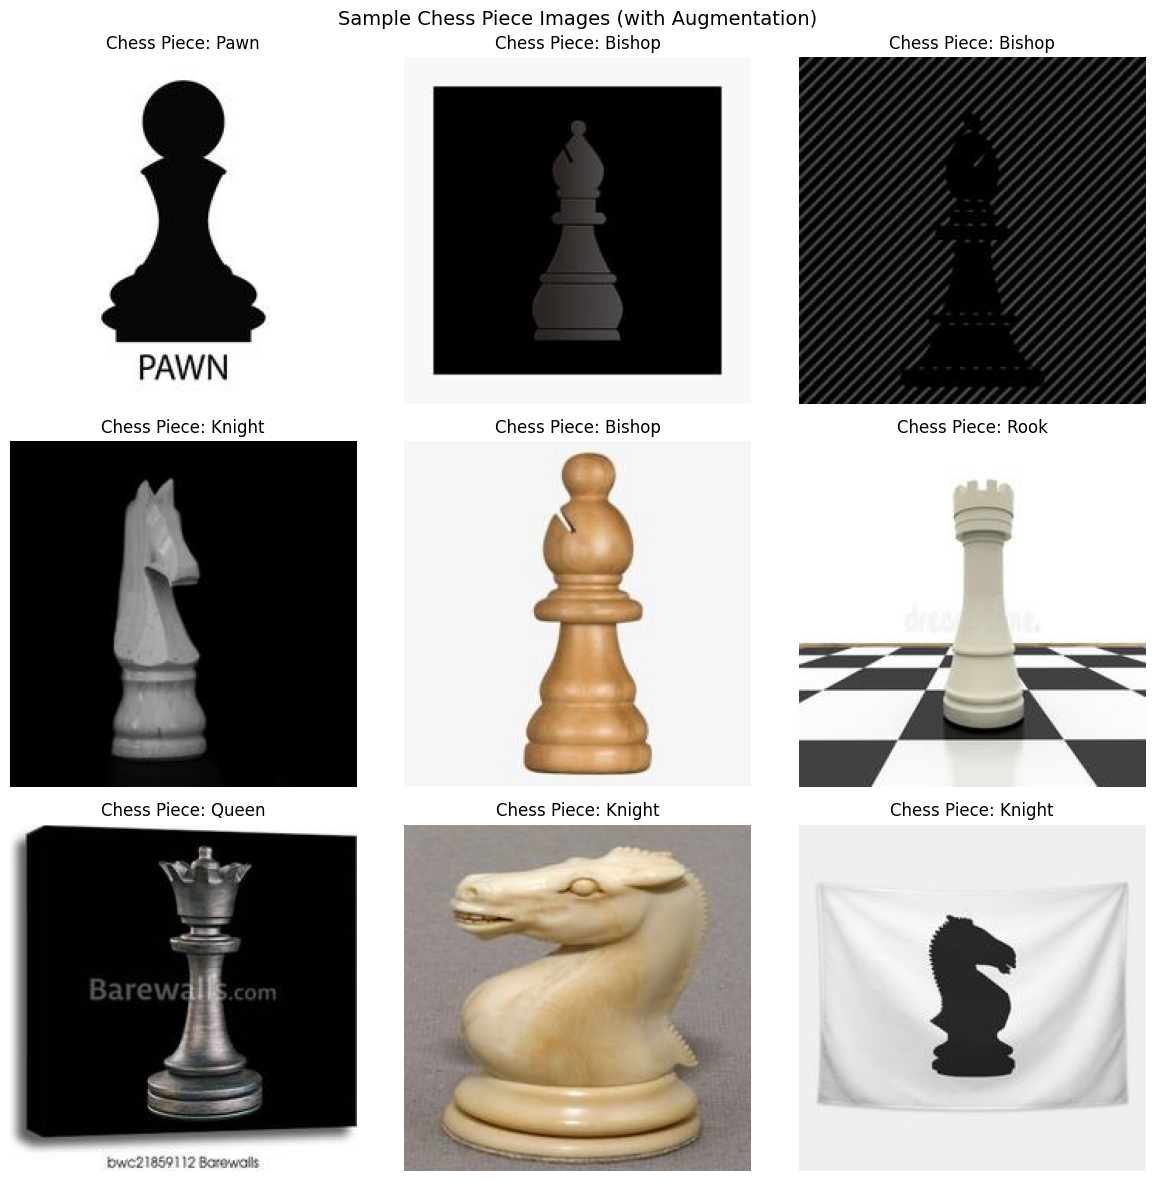

In [27]:
def visualize_samples(generator, class_names, num_samples=9):
    images, labels = next(generator)
    
    plt.figure(figsize=(12, 12))
    
    for i in range(min(num_samples, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        class_idx = np.argmax(labels[i])
        class_name = class_names[class_idx]
        
        plt.title(f'Chess Piece: {class_name}')
        plt.axis('off')
    
    plt.suptitle('Sample Chess Piece Images (with Augmentation)', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_samples(train_generator, CLASS_NAMES)

## Load Pre-trained VGG16 Model

In [28]:
base_model = VGG16(
    weights='imagenet',    
    include_top=False,          
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3) 
)

print("VGG16 base model loaded successfully!")
print(f"\nBase model input shape: {base_model.input_shape}")
print(f"Base model output shape: {base_model.output_shape}")
print(f"Number of layers in base model: {len(base_model.layers)}")

VGG16 base model loaded successfully!

Base model input shape: (None, 224, 224, 3)
Base model output shape: (None, 7, 7, 512)
Number of layers in base model: 19


## Freeze Base Layers (Feature Extraction)


In [29]:
for layer in base_model.layers:
    layer.trainable = False

print("Layer Status After Freezing:")
print("=" * 60)

trainable_count = 0
non_trainable_count = 0

for layer in base_model.layers:
    if layer.trainable:
        trainable_count += 1
        status = "TRAINABLE"
    else:
        non_trainable_count += 1
        status = "FROZEN"
    print(f"{layer.name:25s} | {status}")

print("=" * 60)
print(f"Trainable layers: {trainable_count}")
print(f"Frozen layers: {non_trainable_count}")

Layer Status After Freezing:
input_layer_1             | FROZEN
block1_conv1              | FROZEN
block1_conv2              | FROZEN
block1_pool               | FROZEN
block2_conv1              | FROZEN
block2_conv2              | FROZEN
block2_pool               | FROZEN
block3_conv1              | FROZEN
block3_conv2              | FROZEN
block3_conv3              | FROZEN
block3_pool               | FROZEN
block4_conv1              | FROZEN
block4_conv2              | FROZEN
block4_conv3              | FROZEN
block4_pool               | FROZEN
block5_conv1              | FROZEN
block5_conv2              | FROZEN
block5_conv3              | FROZEN
block5_pool               | FROZEN
Trainable layers: 0
Frozen layers: 19


## Add Custom Classification Head


In [30]:
x = base_model.output

x = GlobalAveragePooling2D(name='global_avg_pool')(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dropout(0.5, name='dropout')(x)
predictions = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

model = Model(inputs=base_model.input, outputs=predictions)

print("Custom classification head added successfully!")
print(f"\nOutput classes: {NUM_CLASSES} ({', '.join(CLASS_NAMES)})")

Custom classification head added successfully!

Output classes: 5 (Bishop, Knight, Pawn, Queen, Rook)


In [31]:
print("Complete Model Architecture:")
print("=" * 80)
model.summary()

trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print("\n" + "=" * 80)
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Total parameters: {trainable_params + non_trainable_params:,}")

Complete Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Trainable parameters: 132,613
Non-trainable parameters: 14,714,688
Total parameters: 14,847,301


In [32]:
model.compile(
    optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),  
    loss='categorical_crossentropy',
    metrics=['accuracy']               
)

print("Model compiled successfully!")
print(f"\nOptimizer: Adam (learning_rate={INITIAL_LEARNING_RATE})")
print("Loss: categorical_crossentropy")
print("Metrics: accuracy")

Model compiled successfully!

Optimizer: Adam (learning_rate=0.001)
Loss: categorical_crossentropy
Metrics: accuracy


In [33]:
print("Starting Initial Training (Feature Extraction Stage)...")
print("=" * 60)
print("VGG16 base layers: FROZEN")
print("Training only: Custom classification head")
print(f"Learning rate: {INITIAL_LEARNING_RATE}")
print(f"Epochs: {INITIAL_EPOCHS}")
print(f"Classes: {CLASS_NAMES}")
print("=" * 60 + "\n")

# Train the model
history_initial = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1
)

print("\nInitial training completed!")

Starting Initial Training (Feature Extraction Stage)...
VGG16 base layers: FROZEN
Training only: Custom classification head
Learning rate: 0.001
Epochs: 10
Classes: ['Bishop', 'Knight', 'Pawn', 'Queen', 'Rook']

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.2311 - loss: 1.7785 - val_accuracy: 0.4844 - val_loss: 1.4871
Epoch 2/10
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4375 - loss: 1.3560

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4375 - loss: 1.3560 - val_accuracy: 0.4609 - val_loss: 1.4781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.3790 - loss: 1.4717 - val_accuracy: 0.4141 - val_loss: 1.3923
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2188 - loss: 1.5666 - val_accuracy: 0.4297 - val_loss: 1.3873
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4808 - loss: 1.3537 - val_accuracy: 0.5469 - val_loss: 1.3056
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5312 - loss: 1.3354 - val_accuracy: 0.5312 - val_loss: 1.3011
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5144 - loss: 1.2398 - val_accuracy: 0.5703 - val_loss: 1.2530
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7188 - loss: 1.1966 - val_accuracy: 0.5781 - val_loss: 1.2571
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5962 - loss: 1.1326 - val_accuracy: 0.5703 - val_loss: 1.

Initial Training Results (Feature Extraction Stage):


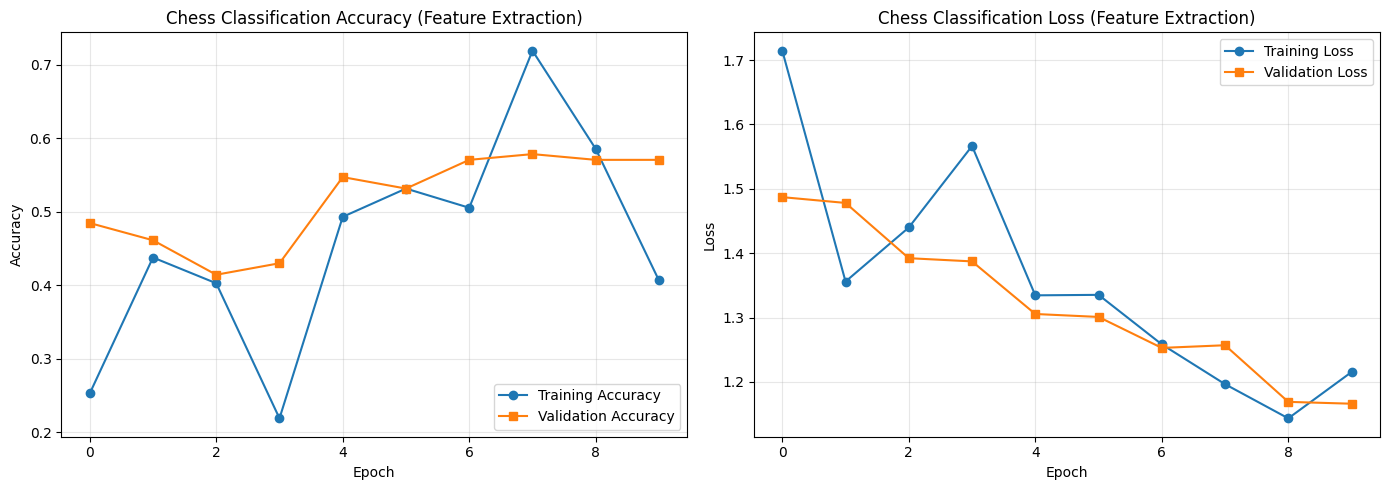

In [34]:
def plot_training_history(history, title_suffix=''):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[0].set_title(f'Chess Classification Accuracy {title_suffix}')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
    axes[1].set_title(f'Chess Classification Loss {title_suffix}')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot initial training results
print("Initial Training Results (Feature Extraction Stage):")
plot_training_history(history_initial, '(Feature Extraction)')

In [35]:
print("Evaluating chess piece classification model on validation set...")
print("=" * 60)

validation_generator.reset()

val_loss, val_accuracy = model.evaluate(
    validation_generator,
    steps=validation_steps,
    verbose=1
)

print("\n" + "=" * 60)
print("FINAL EVALUATION RESULTS - CHESS PIECE CLASSIFICATION")
print("=" * 60)
print(f"Classes: {CLASS_NAMES}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print("=" * 60)

Evaluating chess piece classification model on validation set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5948 - loss: 1.1505

FINAL EVALUATION RESULTS - CHESS PIECE CLASSIFICATION
Classes: ['Bishop', 'Knight', 'Pawn', 'Queen', 'Rook']
Validation Loss: 1.1663
Validation Accuracy: 0.5703 (57.03%)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
Chess Piece Classification Report:
              precision    recall  f1-score   support

      Bishop       0.47      0.48      0.47        29
      Knight       0.67      0.91      0.77        35
        Pawn       0.50      0.12      0.19        17
       Queen       0.38      0.57      0.46        23
        Rook       0.88      0.50      0.64        28

    accuracy                           0.57       132
   macro avg       0.58      0.52      0.51       132
weighted avg       0.60      0.57      0.55       132



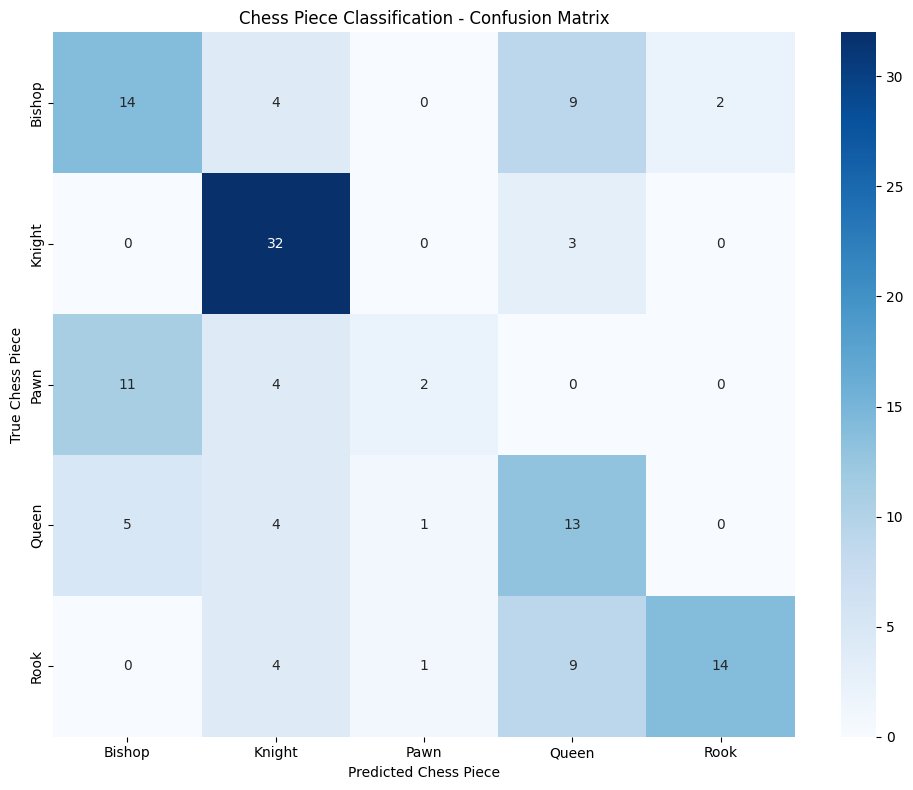

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

validation_generator.reset()

predictions = model.predict(validation_generator, steps=validation_steps + 1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes[:len(predicted_classes)]

print("Chess Piece Classification Report:")
print("=" * 60)
print(classification_report(true_classes, predicted_classes, 
                            target_names=CLASS_NAMES))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Chess Piece Classification - Confusion Matrix')
plt.xlabel('Predicted Chess Piece')
plt.ylabel('True Chess Piece')
plt.tight_layout()
plt.show()